In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import os
from flash.image import ImageClassificationData, ImageClassifier
from flash import Trainer

In [39]:
LOGDIR = 'training-metrics'
NORMALIZED_DATA = '../../Training-baseline/'
EPOCHS = 20
FINETUNE_STRATEGY = 'half-freeze-customLR'
VERSION = (str(EPOCHS) + 'Epochs-' + FINETUNE_STRATEGY)

In [40]:
metrics = pd.read_csv(f'{LOGDIR}/{VERSION}.csv')
display(metrics)

,Unnamed: 0,train_loss,train_acc,val_loss,val_acc,trainf1,valf1
0,0,2.536407,0.414726,2.113049,0.523179,0.080432,0.167586
1,1,1.793144,0.682084,1.517290,0.690728,0.270615,0.369794
2,2,1.261733,0.724914,1.245762,0.683775,0.433019,0.483424
3,3,0.902090,0.720499,1.071491,0.721192,0.572854,0.570911
4,4,0.649899,0.736395,0.995577,0.672517,0.688550,0.614075
5,5,0.462814,0.725356,0.959985,0.674834,0.762273,0.646979
6,6,0.329817,0.721824,0.953619,0.654305,0.816575,0.652091
7,7,0.245566,0.717518,0.931937,0.674503,0.850156,0.673431
8,8,0.180904,0.719174,0.940343,0.691722,0.881961,0.668277
9,9,0.141390,0.717187,0.933932,0.659934,0.894682,0.681257


<AxesSubplot:title={'center':'Loss'}>

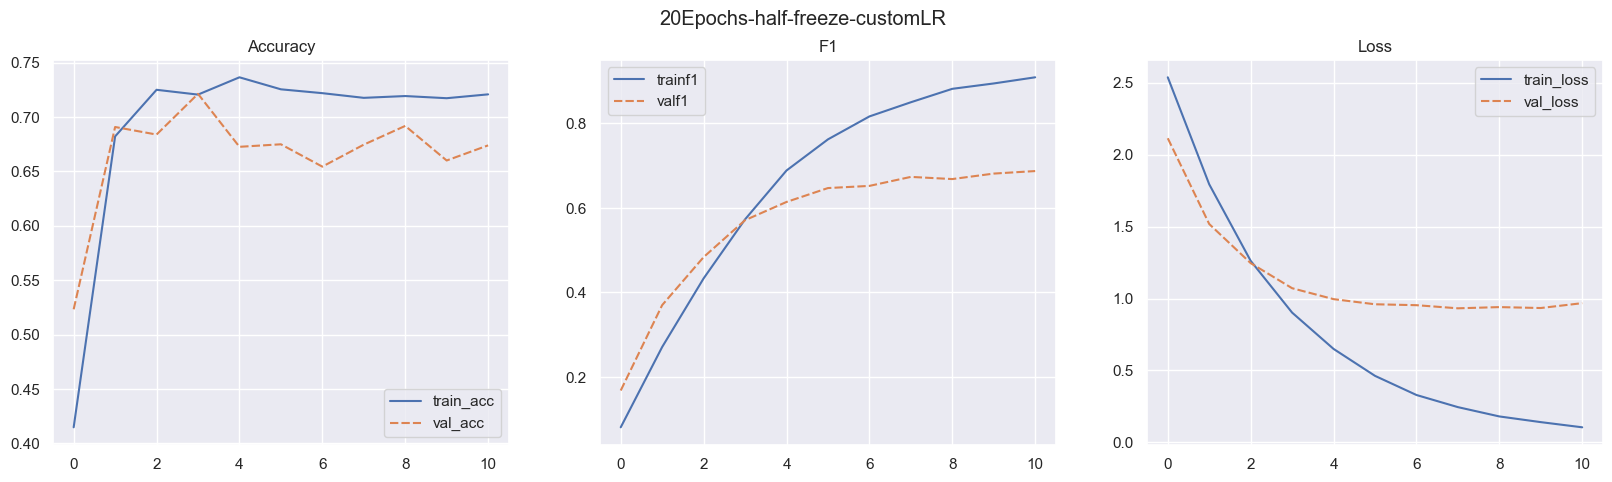

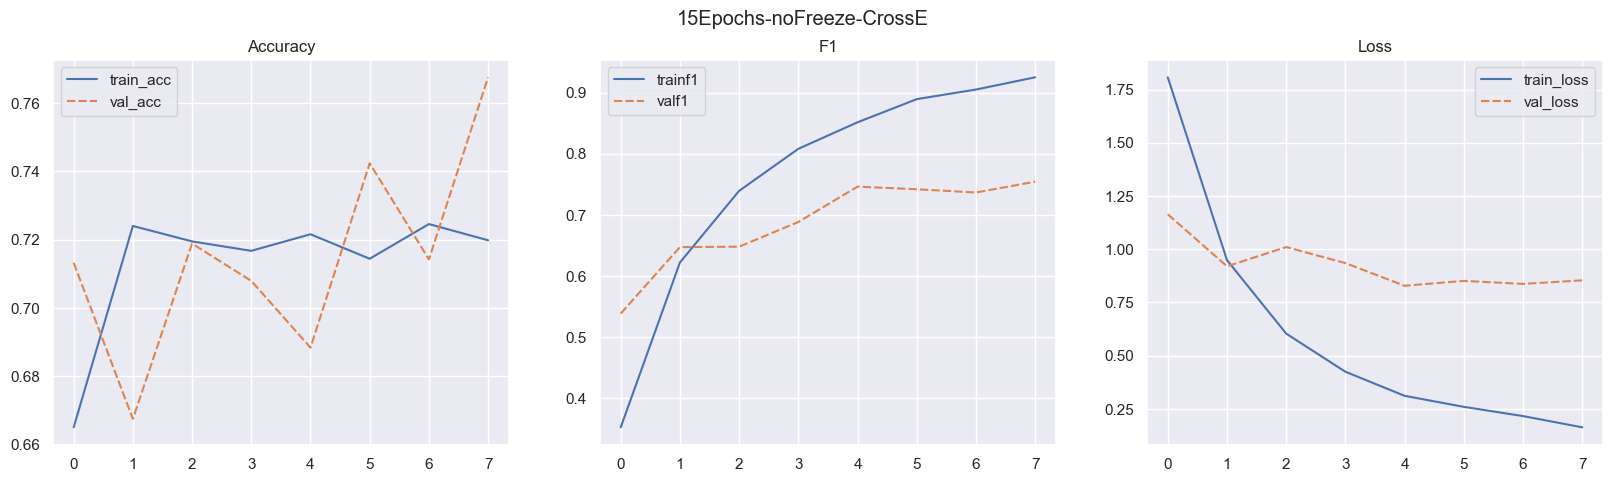

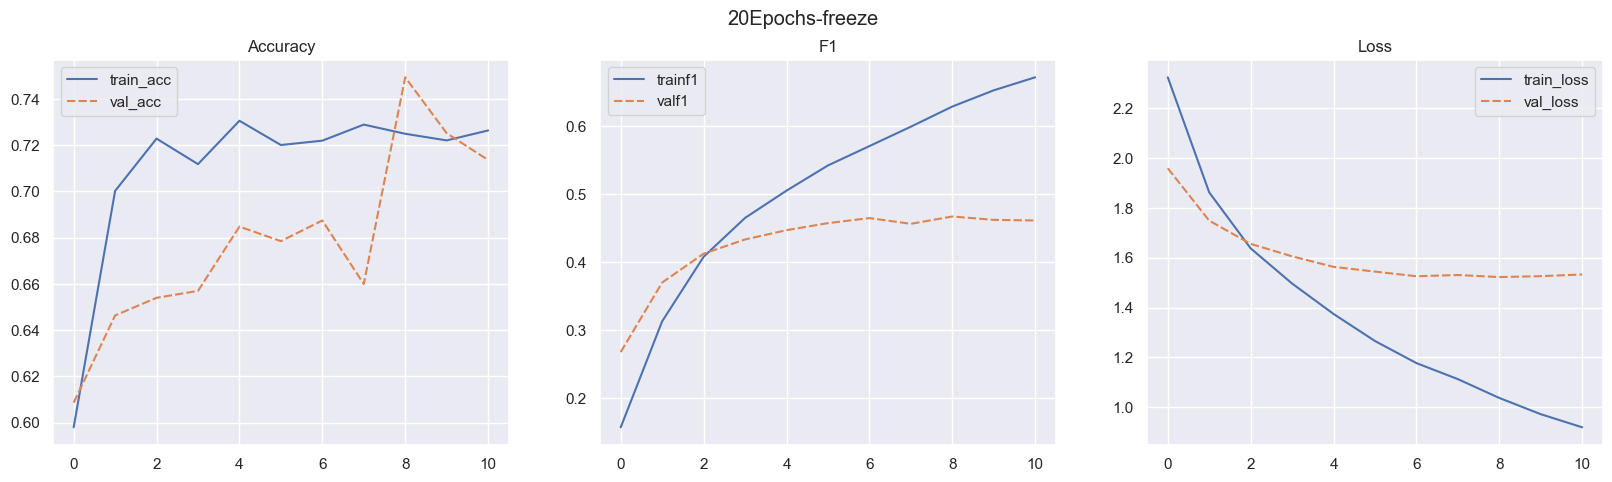

In [41]:
sns.set()

figure, axes = plt.subplots(1, 3, sharex='all', figsize=(20,5))
figure.suptitle(VERSION)
axes[0].set_title('Accuracy')
axes[1].set_title('F1')
axes[2].set_title('Loss')

sns.lineplot(data=metrics[['train_acc', 'val_acc']], ax=axes[0])
sns.lineplot(data=metrics[['trainf1', 'valf1']], ax=axes[1])
sns.lineplot(data=metrics[['train_loss', 'val_loss']], ax=axes[2])

VERSION = '15Epochs-noFreeze-CrossE'
metrics = pd.read_csv(f'{LOGDIR}/{VERSION}.csv')
metrics = metrics.drop(metrics.index[11:])

figure, axes = plt.subplots(1, 3, sharex='all', figsize=(20,5))
figure.suptitle(VERSION)
axes[0].set_title('Accuracy')
axes[1].set_title('F1')
axes[2].set_title('Loss')

sns.lineplot(data=metrics[['train_acc', 'val_acc']], ax=axes[0])
sns.lineplot(data=metrics[['trainf1', 'valf1']], ax=axes[1])
sns.lineplot(data=metrics[['train_loss', 'val_loss']], ax=axes[2])

VERSION = '20Epochs-freeze'
metrics = pd.read_csv(f'{LOGDIR}/{VERSION}.csv')
metrics = metrics.drop(metrics.index[11:])

figure, axes = plt.subplots(1, 3, sharex='all', figsize=(20,5))
figure.suptitle(VERSION)
axes[0].set_title('Accuracy')
axes[1].set_title('F1')
axes[2].set_title('Loss')

sns.lineplot(data=metrics[['train_acc', 'val_acc']], ax=axes[0])
sns.lineplot(data=metrics[['trainf1', 'valf1']], ax=axes[1])
sns.lineplot(data=metrics[['train_loss', 'val_loss']], ax=axes[2])